In [34]:
import torch
import torch.nn.functional as F
import random
import math
import matplotlib.pyplot as plt

In [35]:
file = open("/home/mviswanathsai/Downloads/names.txt", "r")
words = file.read().splitlines()

In [36]:
alphabets = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(alphabets)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [37]:
block_size = 8

def build_dataset(words): 
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 

random.seed(42)
random.shuffle(words)

total_size = len(words)
train_size = int(0.8 * total_size)  # 80%
dev_size = int(0.1 * total_size)    # 10%
test_size = total_size - train_size - dev_size

# 4. Perform the slicing
train_data = words[:train_size]
dev_data = words[train_size : train_size + dev_size]
test_data = words[train_size + dev_size :]

Xtr, Ytr = build_dataset(train_data)
Xdev, Ydev = build_dataset(dev_data)
Xte, Yte = build_dataset(test_data)

In [38]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) 
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out

    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

class BatchNorm1d: 
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.dim = dim 
        self.momentum = momentum 
        self.training = True
        self.eps = eps
        # parameters 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self, x): 
        if self.training: 
            if x.ndim == 2: 
                dim = 0
            elif x.ndim == 3: 
                dim = (0,1)
            xmean = x.mean(dim, keepdims=True) # batch mean
            xvar = x.var(dim, keepdims=True) # batch variance
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        if self.training: 
            with torch.no_grad(): 
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar 
        return self.out 
    def parameters(self): 
        return [self.gamma, self.beta] 

class Tanh: 
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    def parameters(self): 
        return []    

class Embedding: 
    def __init__(self, vocab_size, n_embd): 
        self.weight = torch.randn((vocab_size, n_embd))
    def __call__(self, IX): 
        self.out = self.weight[IX]
        return self.out
    def parameters(self): 
        return [self.weight]

# we want to flatten into group dimensions. I.e, instead of flattening all 8 characters at once, we want to flatten (sets of) 2 at once. 
# so a matrix that was nX8X10 will now become nX4X20. Notice how the 1st dimension was divided by 2 (the number of consecutive characters) 
# and the 2nd dimension was multiplied by 2. This is precisely what we want the FlattenConsecutive layer to do. 
class FlattenConsecutive:
    def __init__(self, n): 
        self.n = n
    def __call__(self, x): 
        A,B,C = x.shape
        n = self.n
        flattened = x.view(A, B//n, C*n)
        self.out = torch.squeeze(flattened, 1) # Remove a dimension with just 1 entry. Because Ax1xC is as good as AxC.
        return self.out
    def parameters(self):
        return []

class Flatten: 
    def __call__(self, x): 
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

class Sequential: 
    def __init__(self, layers): 
        self.layers = layers
    def __call__(self, x): 
        for layer in self.layers: 
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

In [39]:
torch.manual_seed(42)

In [40]:
n_embd = 10 
n_hidden = 200 # to match 22k params
vocab_size = len(itos)
n_consec = 2 

model = Sequential([Embedding(vocab_size, n_embd), 
                    FlattenConsecutive(n_consec), Linear(n_embd * n_consec, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 32x4x20 -> 32x4x200 ->
                    FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # -> 32x2x400 -> 32x2x200 
                    FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # -> 32x400 -> 32x200 ->
                    Linear(n_hidden, vocab_size)])                                                                                  # -> 32x27 i.e, 32 distributions

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): 
    # make minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    x, y = Xtr[ix], Ytr[ix]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)  
    
    # backward propagation 
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    lr = 10**(-1) if i < 150000 else 10**(-2) 
    for p in parameters: 
        p.data += -lr * p.grad

    if i%10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    # track stats
    lossi.append(loss.log10().item())

      0/ 200000: 3.5520
  10000/ 200000: 2.2742
  20000/ 200000: 2.3233
  30000/ 200000: 2.1346
  40000/ 200000: 2.1080
  50000/ 200000: 2.5079
  60000/ 200000: 2.0604
  70000/ 200000: 1.9659
  80000/ 200000: 2.0935
  90000/ 200000: 2.1329
 100000/ 200000: 1.8857
 110000/ 200000: 2.6358
 120000/ 200000: 2.4376
 130000/ 200000: 1.9250
 140000/ 200000: 2.3515
 150000/ 200000: 1.9188
 160000/ 200000: 2.0575
 170000/ 200000: 2.3123
 180000/ 200000: 2.1185
 190000/ 200000: 1.8203


In [28]:
for layer in model.layers: 
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


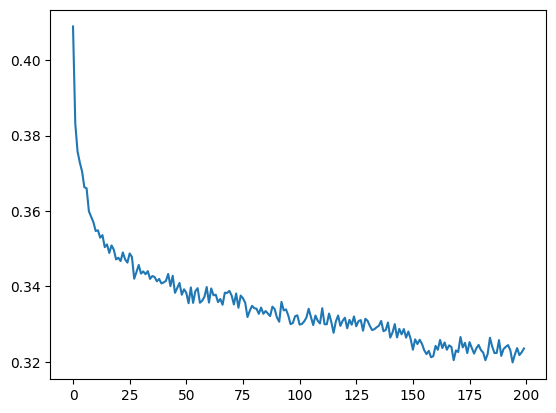

In [30]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [31]:
for layer in model.layers: 
    layer.training = False

In [32]:
@torch.no_grad() # disable gradient book-keeping
def split_loss(string):
    x, y = {
    'test': {Xte, Yte},
    'train': {Xtr, Ytr},
    'dev': {Xdev, Ydev}
    }[string]
    logits = model(x)
    loss = F.cross_entropy(logits, y)    
    print(string + ' loss:', loss.item())

split_loss('test')
split_loss('dev')

test loss: 2.1051268577575684
dev loss: 2.103386402130127


In [33]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True: 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, replacement = True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

lyle.
gwosen.
macoya.
zlikya.
jelanni.
aliyana.
jayah.
ziyah.
hamilinse.
channis.
aluxe.
ellanda.
miliana.
hamry.
denton.
uhsha.
kayali.
covrinn.
koil.
roxam.
